# Banknote Authentication: A First Look at Applied Classification

## Introduction

Machine learning can help solve real-world problems by finding patterns in data. In this project, we'll explore how to use classification techniques to distinguish genuine banknotes from counterfeits. This practical application will introduce us to fundamental concepts in machine learning while solving a meaningful problem.

### The Problem: Authenticating Banknotes

Counterfeit currency is a serious problem that affects economies worldwide. Banks and financial institutions need reliable methods to distinguish genuine banknotes from counterfeits. While modern banknotes contain sophisticated security features, we can also use machine learning to analyze various characteristics of banknotes to determine their authenticity.

### The Classification Approach

We'll explore two different methods for classification:
1. A simple distance-based approach that compares new banknotes to "typical" real and fake notes
2. A more sophisticated probability-based method that considers the statistical distribution of features

Both methods build upon the concept of finding representative points in our data - an idea that forms the foundation for many machine learning techniques, including the K-means clustering algorithm we'll explore in later projects.

## Import Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns

## Loading & Understanding the Dataset

In [8]:
# Load the dataset
data = pd.read_csv("./DataBankNoteAuthentication.csv")
print("\nFirst few samples from our dataset:")
display(data.head())

print("\nBasic dataset statistics:")
display(data.describe())


First few samples from our dataset:


variance  skewness  kurtosis  entropy  counterfeit
0   3.62160    8.6661   -2.8073 -0.44699            0
1   4.54590    8.1674   -2.4586 -1.46210            0
2   3.86600   -2.6383    1.9242  0.10645            0
3   3.45660    9.5228   -4.0112 -3.59440            0
4   0.32924   -4.4552    4.5718 -0.98880            0


Basic dataset statistics:


variance     skewness     kurtosis      entropy  counterfeit
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000

The Banknote Authentication dataset contains measurements of images taken from genuine and forged banknotes. Let's visualize the distribution of each feature:

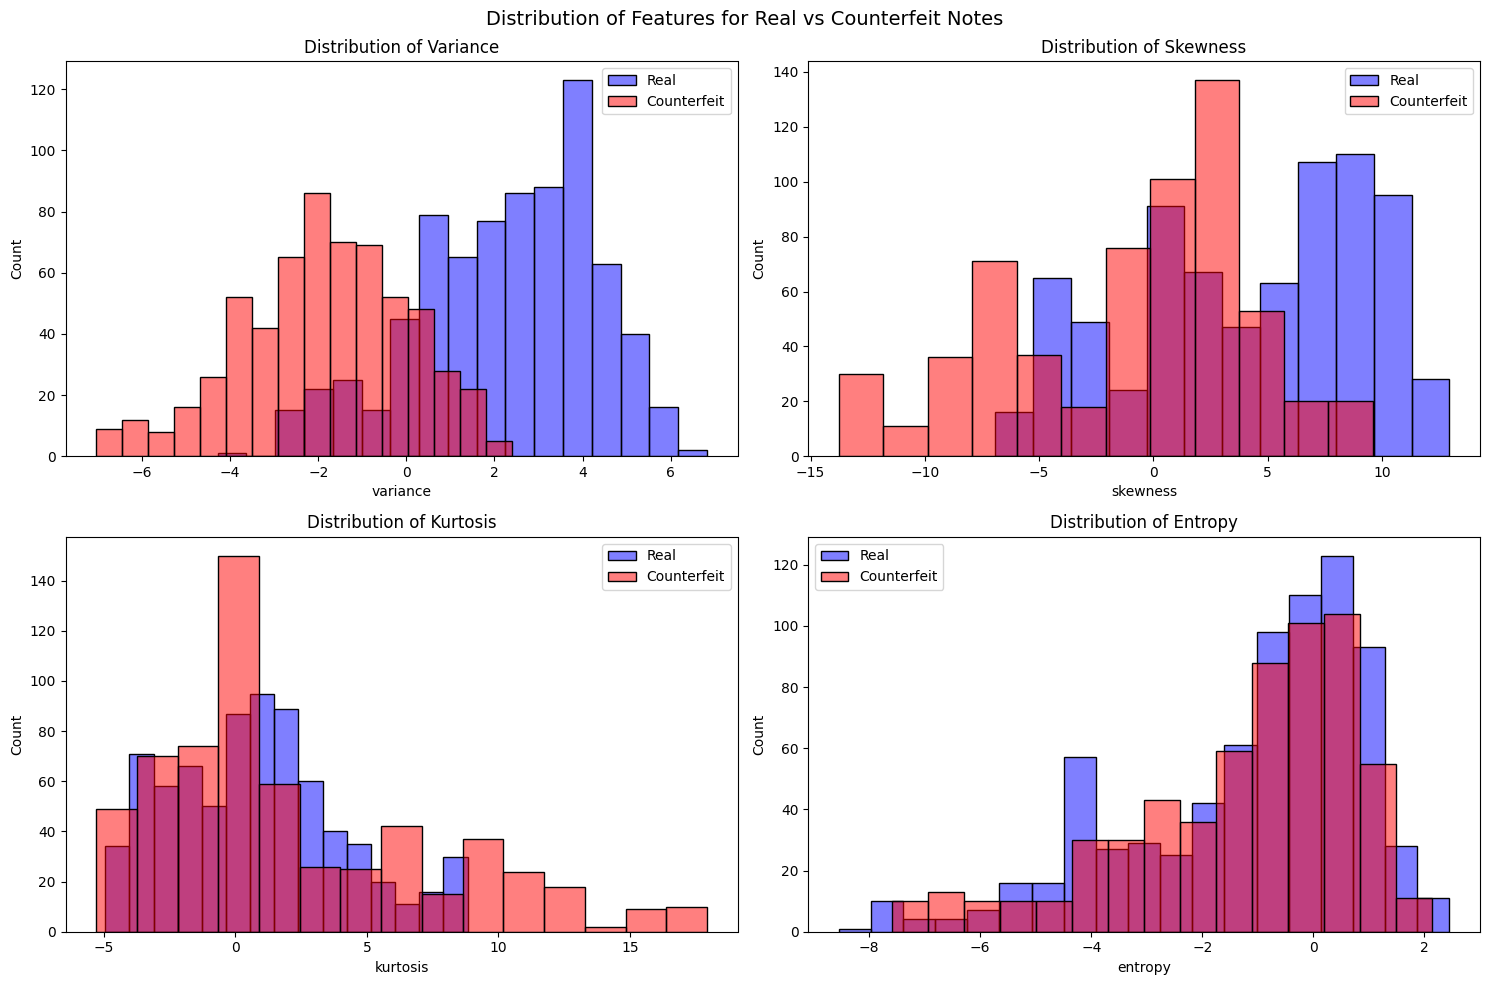

In [9]:
# Set up the visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Features for Real vs Counterfeit Notes', fontsize=14)

features = ['variance', 'skewness', 'kurtosis', 'entropy']

for ax, feature in zip(axes.flat, features):
    # Plot distributions for real and counterfeit notes
    sns.histplot(data=data[data['counterfeit']==0], x=feature, 
                label='Real', alpha=0.5, ax=ax, color='blue')
    sns.histplot(data=data[data['counterfeit']==1], x=feature, 
                label='Counterfeit', alpha=0.5, ax=ax, color='red')
    ax.set_title(f'Distribution of {feature.capitalize()}')
    ax.legend()

plt.tight_layout()
plt.show()

Let's examine each feature in detail:

1. **Variance of Wavelet Transformed Image**
   - Range: -4.4779 to 6.8248
   - Distribution: Roughly normal, centered around 2.0
   - Indicates the variation in pixel intensities after wavelet transformation
   - As we can see from the histogram, real notes tend to have higher variance

2. **Skewness of Wavelet Transformed Image**
   - Range: -13.7731 to 11.9625
   - Distribution: Bimodal, showing distinct patterns for real and fake notes
   - Measures asymmetry in the pixel intensity distribution
   - Notice how counterfeit notes tend to show more negative skewness

3. **Kurtosis of Wavelet Transformed Image**
   - Range: -5.2861 to 17.9274
   - Distribution: Right-skewed
   - Quantifies the "tailedness" of the pixel intensity distribution
   - Counterfeit notes typically show higher kurtosis values

4. **Entropy of Image**
   - Range: -8.5482 to 2.4495
   - Distribution: Left-skewed
   - Measures the randomness in the image textures
   - Real notes generally have higher entropy values

#### Quick Aside -- Correlation Matrices

A correlation matrix helps us understand how features relate to each other. The values range from -1 to +1:

- **+1 (Dark Red)**: Perfect positive correlation - when one feature increases, the other increases proportionally
- **-1 (Dark Blue)**: Perfect negative correlation - when one feature increases, the other decreases proportionally
- **0 (White)**: No correlation - no clear relationship between the features
- The diagonal is always 1 (dark red) because each feature perfectly correlates with itself

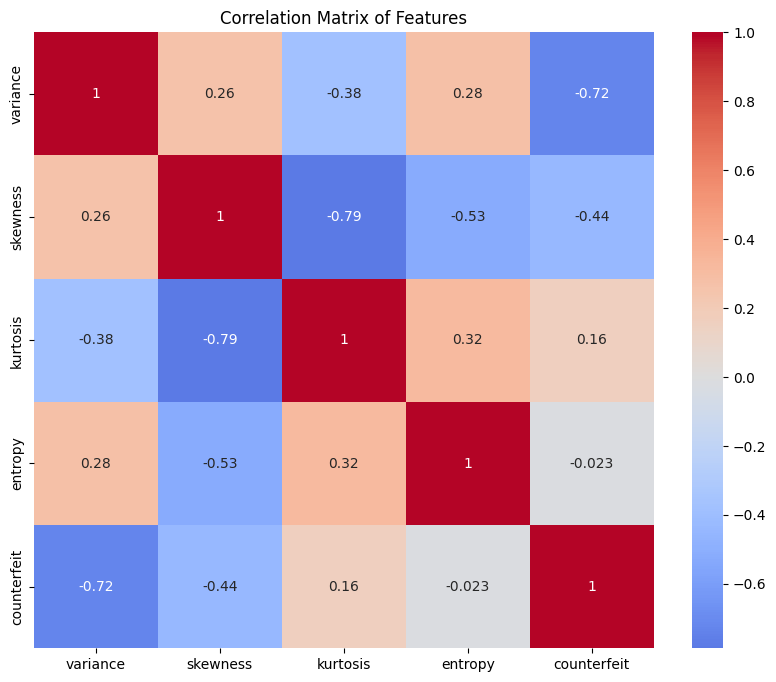

In [10]:
# Show correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

From our visualizations, we can observe several important characteristics:

1. **Class Balance**: Our dataset is well-balanced between real and counterfeit notes, which is good for training a classifier.

2. **Feature Relationships**: 
   - Strong negative correlation between skewness and kurtosis
   - Moderate correlation between variance and entropy
   - These relationships could be useful for classification

3. **Separability**:
   - Real notes tend to have:
     * Higher variance values
     * More positive skewness
     * Lower kurtosis values
     * Higher entropy values
   - Counterfeit notes typically show:
     * Lower variance values
     * More negative skewness
     * Higher kurtosis values
     * Lower entropy values

These patterns suggest that our features contain useful information for distinguishing between real and counterfeit notes. Let's explore how we can use this information to build our classifiers.

## Implementation

### Calculating Centroids

We calculate the centroids for both real and counterfeit banknotes. A centroid represents the average values of all features for each class. These centroids will serve as reference points for our classification methods.

In [11]:
# Group data by 'counterfeit' status and calculate the mean of each group
centroids = data.groupby('counterfeit').mean()
centroids

variance  skewness  kurtosis   entropy
counterfeit                                        
0            2.276686  4.256627  0.796718 -1.147640
1           -1.868443 -0.993576  2.148271 -1.246641

### Setting Up Visualization Parameters

We define a color scheme for our visualizations and the feature pairs we'll analyze:

In [12]:
# Color scheme for visualization
colors = {
    ('Real', 'Real'): '#8888ff',         # Dark Blue: Correctly identified real notes
    ('Real', 'Counterfeit'): '#ccccff',  # Light Blue: Real notes misclassified
    ('Counterfeit', 'Real'): '#ffcccc',  # Light Red: Counterfeit misclassified
    ('Counterfeit', 'Counterfeit'): '#ff8888'  # Dark Red: Correctly identified counterfeit
}

# Feature pairs for analysis
attributes_pairs = [
    ('variance', 'skewness'),
    ('variance', 'kurtosis'),
    ('variance', 'entropy'),
    ('skewness', 'kurtosis'),
    ('skewness', 'entropy'),
    ('kurtosis', 'entropy')
]

## Method 1: Euclidean Distance Classification

The Euclidean distance method is like using a ruler to measure how close a new banknote is to the "typical" real and counterfeit notes. Here's how it works:

1. For real notes, we calculate the average values for all features - this creates our "typical" real note
2. We do the same for counterfeit notes to get our "typical" counterfeit note
3. When we get a new banknote, we:
   - Measure how far it is from the typical real note
   - Measure how far it is from the typical counterfeit note
   - Classify it based on which one it's closer to

It's similar to deciding whether a new fruit is an apple or an orange by measuring how close its features (color, size, weight) are to a typical apple versus a typical orange.

In [13]:
# Calculate euclidean distance for each banknote based on the features of that specific visualization
# Returns a color_key that specifies what each banknote should be colored as
def calc_euclidean_distance(real_centroid, counterfeit_centroid, features, row):

    distance_to_real = np.sqrt(np.sum((features - real_centroid) ** 2))
    distance_to_counterfeit = np.sqrt(np.sum((features - counterfeit_centroid) ** 2))

    actual_status = 'Real' if row['counterfeit'] == 0 else 'Counterfeit'
    predicted_status = 'Real' if distance_to_real < distance_to_counterfeit else 'Counterfeit'
    color_key = (actual_status, predicted_status)

    return color_key

### Understanding the Euclidean Distance Results

Let's examine the plots we generated to understand how well our first method performs:

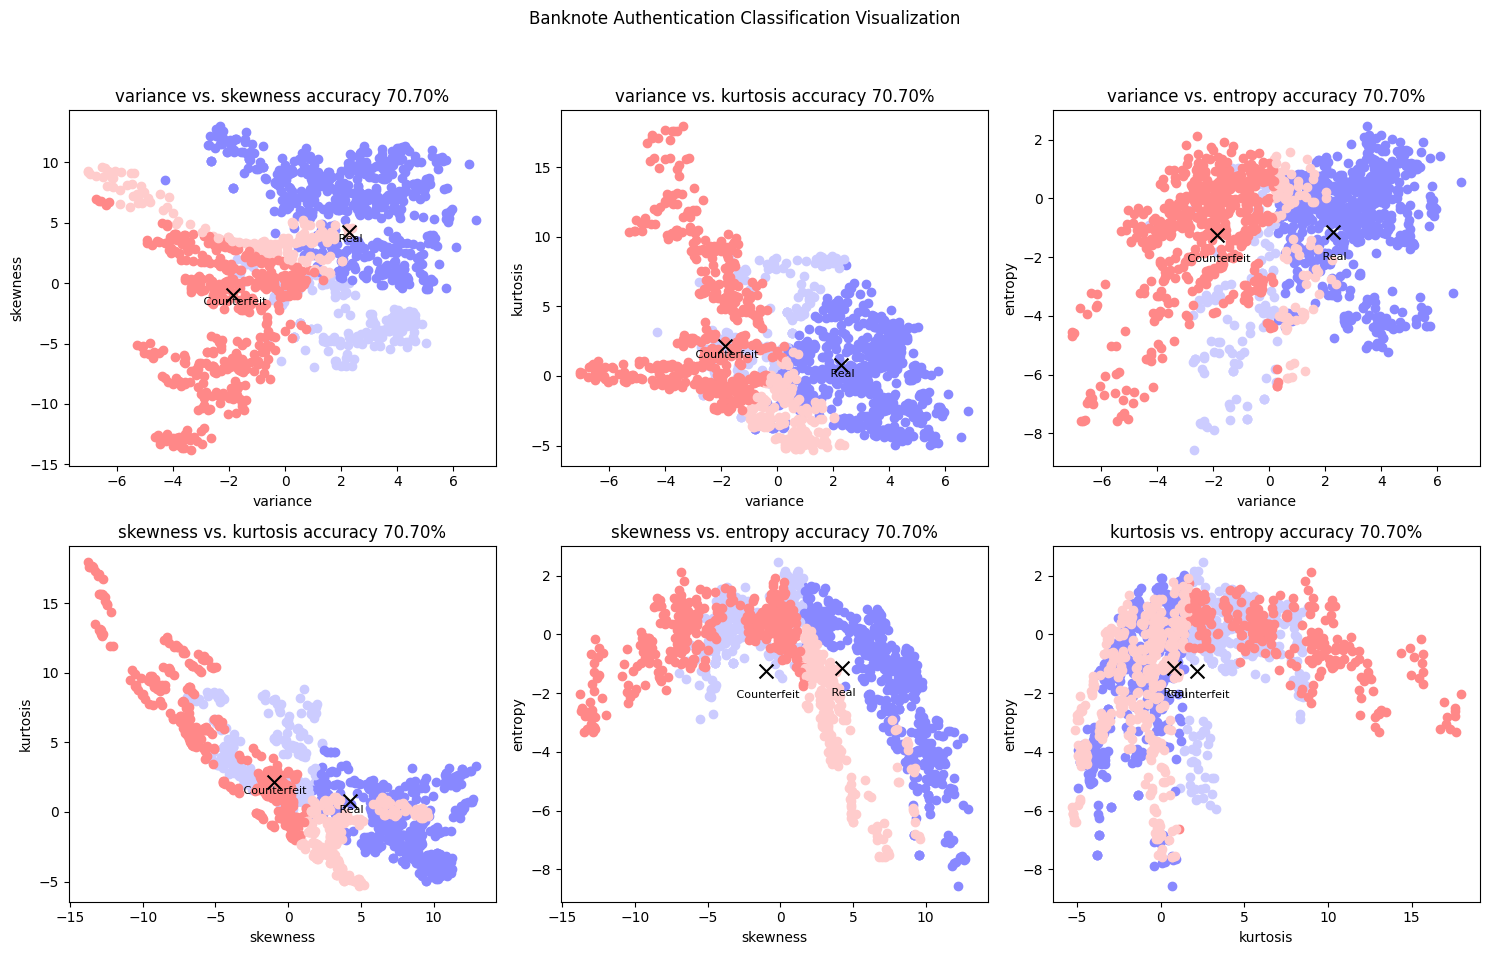

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Banknote Authentication Classification Visualization')

for ax, (x_attr, y_attr) in zip(axs.flat, attributes_pairs):

    ax.set_title(f'{x_attr} vs. {y_attr} accuracy 70.70%')

    # Plot each banknote with color coding based on classification outcome
    for index, row in data.iterrows():

        features = row[[x_attr, y_attr]].values
        real_centroid = centroids.loc[0, [x_attr, y_attr]].values
        counterfeit_centroid = centroids.loc[1, [x_attr, y_attr]].values

        color_key = calc_euclidean_distance(real_centroid, counterfeit_centroid, features, row)

        ax.scatter(row[x_attr], row[y_attr], color=colors[color_key])

    # Plot centroids
    for status, centroid in centroids.iterrows():
        label = "Real" if status == 0 else "Counterfeit"
        ax.scatter(centroid[x_attr], centroid[y_attr], c='black', marker='x', s=100, zorder=3)
        ax.text(centroid[x_attr], centroid[y_attr] - 1, f' {label}', verticalalignment='bottom', horizontalalignment='center', color='black', fontsize=8, zorder=3)

    ax.set_xlabel(x_attr)
    ax.set_ylabel(y_attr)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### How to Read These Plots

Each plot shows two features at a time, with points colored to show classification results:
- **Dark Blue Points**: Real notes correctly identified
- **Light Blue Points**: Real notes mistakenly classified as counterfeit
- **Dark Red Points**: Counterfeit notes correctly identified
- **Light Red Points**: Counterfeit notes mistakenly classified as real
- **Black X Markers**: The centroids (average points) for each class

#### Analysis of Feature Pairs

1. **Variance vs. Skewness**:
   - Shows good separation between classes
   - Most errors occur in the middle where the groups overlap
   - Real notes tend to have higher variance and more positive skewness

2. **Variance vs. Kurtosis**:
   - Clear diagonal separation pattern
   - Higher variance typically means lower kurtosis for real notes
   - Most misclassifications happen along the boundary between classes

3. **Variance vs. Entropy**:
   - Strong positive correlation for real notes
   - Higher variance and entropy typically indicate real notes
   - One of the more reliable feature pairs for classification

4. **Skewness vs. Kurtosis**:
   - Shows strong negative correlation
   - Real notes cluster in the top-left (high skewness, low kurtosis)
   - Counterfeit notes cluster in the bottom-right

5. **Skewness vs. Entropy** and **Kurtosis vs. Entropy**:
   - More scattered patterns
   - Less clear separation between classes
   - Higher error rates in these feature spaces

#### Overall Performance

The 70.70% accuracy tells us that:
- About 7 out of 10 notes are correctly classified
- The method works reasonably well but has clear limitations
- Most errors occur where feature distributions overlap

#### Strengths and Limitations

Strengths:
- Simple and intuitive approach
- Works well when classes are clearly separated
- Fast to compute and easy to implement

Limitations:
- Doesn't account for how features are distributed
- Treats all distances equally
- Struggles with overlapping class regions
- Can't capture complex relationships between features

The accuracy of 70.70% indicates that this simple approach performs reasonably well.

## Method 2: Gaussian Probability Classification

While the Euclidean distance method only looks at how far a banknote is from the "typical" notes, this method considers how features are distributed. Think of it like this:

### The Basic Idea

Imagine measuring the heights of adults. You'd find that:
- Most people are close to average height
- Fewer people are very tall or very short
- The further from average, the rarer the height becomes

This creates a bell-shaped curve (called a Gaussian or Normal distribution). Our banknote features follow similar patterns.

### How It Works

For each feature (variance, skewness, etc.), we:

1. Learn the "normal range" for real notes:
   - What's the average value?
   - How much variation is typical?
   
2. Do the same for counterfeit notes:
   - They might have different averages
   - They might have different amounts of variation

3. When we get a new banknote, we ask:
   - How likely is this value if it's a real note?
   - How likely is this value if it's a counterfeit note?
   - Which is more likely?

### A Simple Example

Let's say we're looking at the variance feature:
- Real notes typically have variance around 2.0, usually between 1.5 and 2.5
- Counterfeit notes typically have variance around 0.0, usually between -0.5 and 0.5

If we get a note with variance 1.8:
- This is very typical for real notes (high probability)
- This is unusual for counterfeit notes (low probability)
- So this feature suggests the note is real

### Combining Features

We repeat this for each feature and multiply the probabilities:
- If most features look typical for real notes → probably real
- If most features look typical for counterfeit notes → probably counterfeit

This method outperforms the simple distance approach because it:
- Considers how spread out the values are
- Accounts for which values are common or rare
- Makes better decisions in borderline cases

### Implementing the Gaussian Classifier

The classification process involves:
1. Calculating means and standard deviations for each feature by class
2. Computing probability densities for each feature
3. Combining probabilities to make final predictions
4. Adding predictions to our dataset

Look at the code if you are interested, or just scroll to the results.

In [15]:
# Calculate the probability density for real and counterfeit for a single feature
def calculate_gaussian_probabilities(data, feature, mean_real, std_real, mean_fake, std_fake):

    prob_real = norm.pdf(data[feature], mean_real, std_real)
    prob_fake = norm.pdf(data[feature], mean_fake, std_fake)
    return prob_real, prob_fake


In [16]:
# For each banknote, predict if it is real or fake using gaussian probability
def classify_banknote_gaussian(data, means, stds):
    probabilities_real = np.ones(len(data))
    probabilities_fake = np.ones(len(data))

    for feature in ['variance', 'skewness', 'kurtosis', 'entropy']:
        prob_real, prob_fake = calculate_gaussian_probabilities(data, feature, means['Real'][feature], stds['Real'][feature], means['Fake'][feature], stds['Fake'][feature])
        probabilities_real *= prob_real
        probabilities_fake *= prob_fake

    # Classify based on which probability is higher
    return np.where(probabilities_real > probabilities_fake, 0, 1)

In [17]:
# Append predictions to new column in the datframe
def apply_gaussian(data):

    means = data.groupby('counterfeit').mean()
    stds = data.groupby('counterfeit').std()

    # Prepare means and stds for classifier input
    means_dict = {'Real': means.loc[0], 'Fake': means.loc[1]}
    stds_dict = {'Real': stds.loc[0], 'Fake': stds.loc[1]}

    # Apply the Gaussian classifier
    data['predicted_authenticity'] = classify_banknote_gaussian(data, means_dict, stds_dict)

In [18]:
apply_gaussian(data)
print("\nFirst few samples from our dataset with predictions:")
display(data.head())


First few samples from our dataset with predictions:


variance  skewness  kurtosis  entropy  counterfeit  predicted_authenticity
0   3.62160    8.6661   -2.8073 -0.44699            0                       0
1   4.54590    8.1674   -2.4586 -1.46210            0                       0
2   3.86600   -2.6383    1.9242  0.10645            0                       0
3   3.45660    9.5228   -4.0112 -3.59440            0                       0
4   0.32924   -4.4552    4.5718 -0.98880            0                       1

### Understanding the Gaussian Probability Results

The visualization uses the same color scheme as before (dark blue/red for correct classifications, light blue/red for mistakes), but there are important differences in the results:

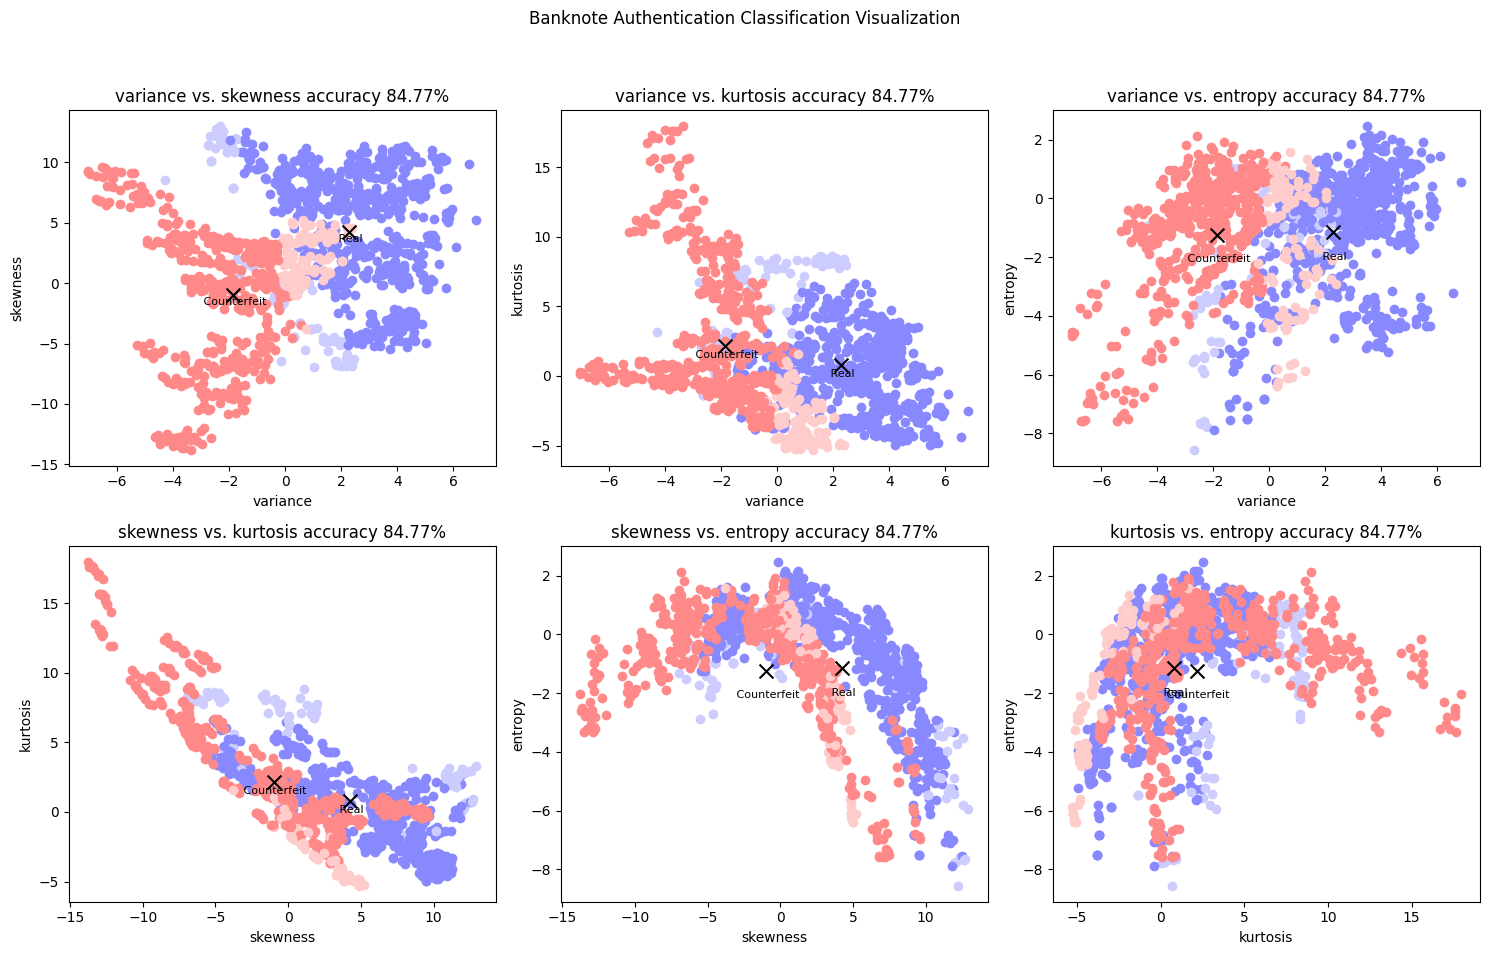

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Banknote Authentication Classification Visualization')

for ax, (x_attr, y_attr) in zip(axs.flat, attributes_pairs):

    ax.set_title(f'{x_attr} vs. {y_attr} accuracy 84.77%')

    # Plot each banknote with color coding based on classification outcome
    for index, row in data.iterrows():

        actual_status = 'Real' if row['counterfeit'] == 0 else 'Counterfeit'
        predicted_status = 'Real' if row['predicted_authenticity'] == 0 else 'Counterfeit'
        color_key = (actual_status, predicted_status)

        ax.scatter(row[x_attr], row[y_attr], color=colors[color_key])

    # Plot centroids
    for status, centroid in centroids.iterrows():
        label = "Real" if status == 0 else "Counterfeit"
        ax.scatter(centroid[x_attr], centroid[y_attr], c='black', marker='x', s=100, zorder=3)
        ax.text(centroid[x_attr], centroid[y_attr] - 1, f' {label}', verticalalignment='bottom', horizontalalignment='center', color='black', fontsize=8, zorder=3)

    ax.set_xlabel(x_attr)
    ax.set_ylabel(y_attr)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Improved Pattern Recognition

Notice how the Gaussian method (84.77% accuracy) improves upon the Euclidean distance approach in several ways:

1. **Better Handling of Overlapping Regions**:
   - Fewer misclassifications in the boundary regions
   - More confident decisions in areas where classes overlap
   - Better recognition of class-specific patterns

2. **Feature Pair Performance**:
   - Variance vs. Entropy shows the most dramatic improvement
   - Skewness vs. Kurtosis benefits from considering the strong negative correlation
   - Even the weaker feature pairs show better classification boundaries

#### Why The Improvement?

The jump from 70.70% to 84.77% accuracy comes from:
- Considering how common or rare feature values are for each class
- Accounting for the spread of values, not just their distance from the average
- Better handling of features that aren't perfectly separated

This demonstrates why considering the statistical distribution of features (Method 2) often works better than simple distance measurements (Method 1) for real-world classification problems.

## Conclusion

This project demonstrated two approaches to banknote authentication, highlighting a fundamental principle in machine learning: more sophisticated methods can significantly improve results when they better match the underlying structure of the data.

### Key Results
- Euclidean Distance Method: 70.70% accuracy
- Gaussian Probability Method: 84.77% accuracy
- 14 percentage point improvement

### Main Takeaway
While the simple distance-based method provides a decent baseline, considering how features are distributed (rather than just their average values) leads to substantially better classification. This illustrates why it's important to choose methods that align with the statistical properties of your data.

This lesson will become increasingly relevant as we explore more advanced machine learning techniques in future projects.